(import_mutations_from_tskit_vignette)=

# Importing mutations from tskit

In [1]:
import msprime

ts = msprime.sim_ancestry(1000,
                          recombination_rate=1e-9,
                          sequence_length=1e6,
                          population_size=1000,
                          random_seed=54321)

Make a copy of the tables to work with:

In [2]:
tables = ts.tables

Add the `fwdpy11` mutation metadata schema:

In [3]:
import fwdpy11

tables.mutations.metadata_schema = fwdpy11.tskit_tools.metadata_schema.MutationMetadata

Get a list of candidate edges:

In [4]:
edge_indexes = []
edge_weights = []

for i in range(0, tables.edges.num_rows):
    edge = tables.edges[i]
    ptime = tables.nodes.time[edge.parent]
    ctime = tables.nodes.time[edge.child]
    # We must assign mutations integer-valued
    # times to be compatible with discrete-time
    # forward simulations.  To do so, we filter
    # on branches greater than a generation long.
    if ptime - ctime > 1.0:
        edge_indexes.append(i)
        edge_weights.append((ptime-ctime)*(edge.right - edge.left))

We will add 10 mutations to our table collection:

* Effect sizes will be `N(0, 0.1)`.
* Dominance will be 1.

First, choose 10 random edges:

In [5]:
import numpy as np
np.random.seed(666 * 42)

edge_weights = np.array(edge_weights)
edge_weights /= np.sum(edge_weights)

chosen_edges = np.random.choice(edge_indexes, size=10, p=edge_weights)

::: {warning}
The method used here to obtain candidate branches for placing mutations and sampling them is **absolutely the wrong thing to do**.
The code shown above is for illustration purposes here.
The approach used here violates many core evolutionary principles!
:::

In [6]:
# We must make sure that mutations
# occur at unique sites because fwdpy11
# is limited to the infinitely-many sites model.
sites = set()
for i in chosen_edges:
    edge = tables.edges[i]

    position = np.random.uniform(edge.left, edge.right, 1)[0]
    while position in sites:
        position = np.random.uniform(edge.left, edge.right, 1)[0]
    sites.add(position)

    site = tables.sites.add_row(position, '0')
    effect_size = np.random.normal(loc=0.0, scale=0.1, size=1)[0]

    # Here, we cheat and take the largest integer value >=
    # the node child time.  In production, something else
    # should be done
    time = np.ceil(tables.nodes.time[edge.child])
    assert time < tables.nodes.time[edge.parent]
    print(time, position, effect_size)

    # Build the mutation metadata
    md = {'s': effect_size,
          'h': 1.0,
          'origin': int(time),
          # NOTE: always write the
          # next 3 lines as shown here.
          # The fwdpy11 back end will do
          # the right thing.
          # A future release will provide a
          # nicer API so that you only need
          # to provide the previous 3 fields.
          'neutral': 0,
          'label': np.uint16(0),
          'key': np.uint64(0)
         }
    tables.mutations.add_row(site, edge.child,
                             '1', time=time,
                             metadata=md)

tables.sort()
ts_with_muts = tables.tree_sequence()

0.0 717675.0202841847 -0.09416348302168775
0.0 334533.269926062 -0.09736733068422934
3.0 278839.69879464066 -0.09699368156361998
0.0 876040.4676970788 0.1871315865646086
0.0 988677.2736629287 0.06603697668387988
19.0 831547.6330477025 -0.02066488387394409
1569.0 89952.98209790065 0.11693668731955759
65.0 660275.1659338316 0.021086200504333266
1.0 285467.46704960876 -0.065294442775488
3.0 910161.6249156992 -0.08501405494395672


Create a population and lift over the mutations:

In [7]:
pop = fwdpy11.DiploidPopulation.create_from_tskit(ts_with_muts, import_mutations=True)

Print the number of times each mutation appears in the population and its internal data:

In [8]:
for c, m in zip(pop.mcounts, pop.mutations):
    print(c, "->", m)

799 -> Mutation[position:89952.982098, effect size:0.116937, dominance:1.000000, origin time:-1569, label:0]
4 -> Mutation[position:278839.698795, effect size:-0.096994, dominance:1.000000, origin time:-3, label:0]
2 -> Mutation[position:285467.467050, effect size:-0.065294, dominance:1.000000, origin time:-1, label:0]
1 -> Mutation[position:334533.269926, effect size:-0.097367, dominance:1.000000, origin time:0, label:0]
27 -> Mutation[position:660275.165934, effect size:0.021086, dominance:1.000000, origin time:-65, label:0]
1 -> Mutation[position:717675.020284, effect size:-0.094163, dominance:1.000000, origin time:0, label:0]
4 -> Mutation[position:831547.633048, effect size:-0.020665, dominance:1.000000, origin time:-19, label:0]
1 -> Mutation[position:876040.467697, effect size:0.187132, dominance:1.000000, origin time:0, label:0]
3 -> Mutation[position:910161.624916, effect size:-0.085014, dominance:1.000000, origin time:-3, label:0]
1 -> Mutation[position:988677.273663, effect 

Set up a model of additive effects on a phenotype and Gaussian stabilizing
selection with an optimum of 1 and the (inverse) strength of stabilizing
selection is also 1.0.

::: {note}
Pay attention to the recombination rate here: it is per genome in `fwdpy11`
but per "base pair" in `msprime`!
:::

In [9]:
pdict = {'nregions': [], 'sregions': [],
         'recregions': [fwdpy11.PoissonInterval(0, pop.tables.genome_length,
                                                1e-9*pop.tables.genome_length)],
         'rates': (0., 0., None),
         'gvalue': fwdpy11.Additive(scaling=2, 
                                     gvalue_to_fitness=fwdpy11.GSS(optimum=1.0, VS=1.0)),
         'simlen': 100,
         'demography': fwdpy11.DiscreteDemography(),
         'prune_selected': False
         }
params = fwdpy11.ModelParams(**pdict)

Set up recording some data:

In [10]:
from dataclasses import dataclass

@dataclass
class SimData:
    generation: int
    mean_phenotype: float
    mean_fitness: float

@dataclass
class Recorder:
    data: list

    def __call__(self, pop, _):
        md = np.array(pop.diploid_metadata)
        mean_pheno = md['g'].mean()
        mean_fitness = md['w'].mean()
        self.data.append(SimData(pop.generation, mean_pheno, mean_fitness))

Run the simulation:

In [11]:
rng = fwdpy11.GSLrng(2351235)
recorder = Recorder(data = [])
fwdpy11.evolvets(rng, pop, params, simplification_interval=50,
                 recorder=recorder, suppress_table_indexing=True)
assert pop.generation == 100

Plot our results:

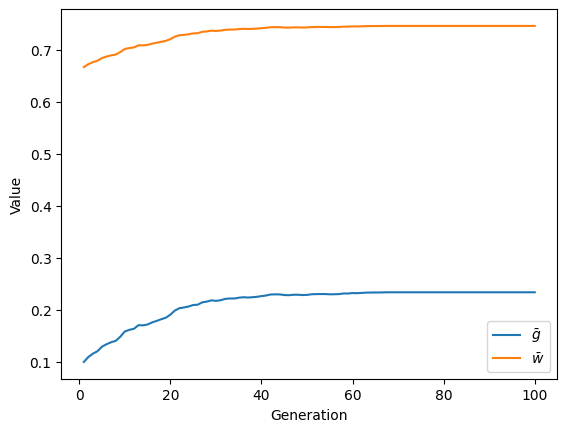

In [12]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
g = [i.generation for i in recorder.data]
p = [i.mean_phenotype for i in recorder.data]
w = [i.mean_fitness for i in recorder.data]
ax.plot(g, p, label=r'$\bar{g}$')
ax.plot(g, w, label=r'$\bar{w}$')
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.legend(loc='best');

What mutations are left at the end of the sim?

In [13]:
for c, m in zip(pop.mcounts, pop.mutations):
    print(c, "->", m)

2000 -> Mutation[position:89952.982098, effect size:0.116937, dominance:1.000000, origin time:-1569, label:0]
